In [1]:
import time, os, pdb, pickle, argparse, shutil
from solver_encoder import Solver 
from data_loader import get_loader
from torch.backends import cudnn
import torch, math, utils, time, pdb, datetime
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import medfilt
import torch.nn.functional as F

In [2]:
model_dir = 'model_data'
model_name = '1Hot16FreqFrom400kIters'
one_hot=True
ckpt_iters = 700000
config = pickle.load(open('./' +model_dir +'/' +model_name +'/' +'config.pkl','rb'))
config

Namespace(adam_init=0.0001, batch_size=2, ckpt_freq=100000, data_dir='./spmel', dim_emb=20, dim_neck=32, dim_pitch=257, dim_pre=512, file_name='1Hot16FreqFrom400kIters', freq=16, lambda_cd=1, len_crop=128, load_ckpts='./model_data/1Hot16Freq/ckpts/ckpt_400000.pth.tar', log_step=10, num_iters=1000000, one_hot=True, prnt_loss_weight=1.0, psnt_loss_weight=1.0, shape_adapt=True, spec_freq=10000, train_size=20, which_cuda=1)

In [3]:
cudnn.benchmark = True
use_cuda = torch.cuda.is_available()
device = torch.device(f'cuda:{config.which_cuda}' if use_cuda else 'cpu')
data_loader = get_loader(config)
# solver = Solver(vcc_loader, config)
# solver.train()

Finished loading the dataset...


In [4]:
from model_vc import Generator

G = Generator(config.dim_neck, config.dim_emb, config.dim_pitch, config.dim_pre, config.freq)

g_optimizer = torch.optim.Adam(G.parameters(), config.adam_init)

g_checkpoint = torch.load(config.load_ckpts)
G.load_state_dict(g_checkpoint['model_state_dict'])
g_optimizer.load_state_dict(g_checkpoint['optimizer_state_dict'])
# pdb.set_trace()
# fixes tensors on different devices error
# https://github.com/pytorch/pytorch/issues/2830
for state in g_optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.cuda(config.which_cuda)
previous_ckpt_iters = g_checkpoint['iteration']

G.to(device)
G = G.eval()

def reset_grad():
    """Reset the gradient buffers."""
    g_optimizer.zero_grad()

print('model loaded')

model loaded


In [5]:
def before_after_mels(tensor):
    for mels in tensor.squeeze(1).detach().cpu().numpy():
        mels = np.rot90(mels)
        plt.imshow(mels, cmap='gray')
        plt.show() 

x_real


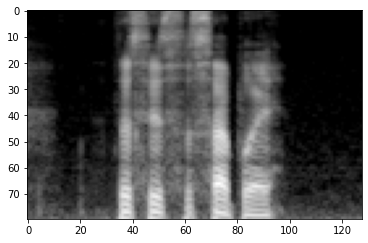

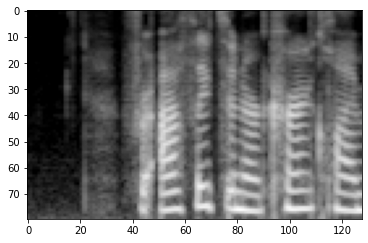

x_identic_psnt


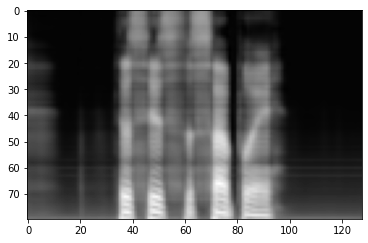

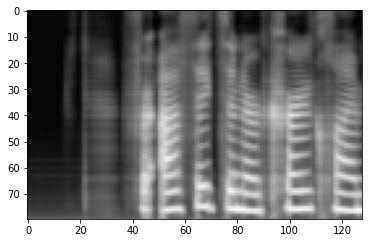

speaker_ids: p347p303


In [6]:
""" USING TENSORS GENERATED DIRECTLY FROM THE DATA_LOADER"""

try:
    x_real, emb_org, speaker_name, pitch = next(data_iter)
except:
    data_iter = iter(data_loader)
    x_real, emb_org, speaker_name, pitch = next(data_iter)

x_real_tensor = x_real.to(device)
emb_org_tensor = emb_org.to(device).float()
pitch_tensor = pitch.to(device).float()

_, x_identic_psnt_tensor, _ = G(x_real_tensor, emb_org_tensor, emb_org_tensor, pitch_tensor, pitch_tensor)


torch.save(x_real_tensor, './model_data/' +config.file_name +'/image_comparison/mel_batch_' +speaker_name[0] +speaker_name[1] +'.pt')
torch.save(pitch_tensor, './model_data/' +config.file_name +'/image_comparison/pitch_' +speaker_name[0] +speaker_name[1] +'.pt')
torch.save(emb_org_tensor, './model_data/' +config.file_name +'/image_comparison/emb_org_' +speaker_name[0] +speaker_name[1] +'.pt')
torch.save(x_identic_psnt_tensor, './model_data/' +config.file_name +'/image_comparison/x_identic_psnt_' +speaker_name[0] +speaker_name[1] +'.pt')

print('x_real')
before_after_mels(x_real_tensor)

print('x_identic_psnt')
before_after_mels(x_identic_psnt_tensor)

print('speaker_ids: ' +speaker_name[0] +speaker_name[1])

x_real_tensor torch.Size([2, 128, 80])
emb_org_tensor torch.Size([2, 20])
pitch_tensor torch.Size([2, 128, 257])
<class 'torch.Tensor'> torch.Size([2, 128, 80]) tensor([[[0.5717, 0.7333, 0.7079,  ..., 0.2560, 0.2380, 0.2104],
         [0.5732, 0.7324, 0.6990,  ..., 0.2770, 0.2570, 0.2375],
         [0.5773, 0.7316, 0.6954,  ..., 0.2540, 0.2280, 0.2148],
         ...,
         [0.3383, 0.2866, 0.2209,  ..., 0.0000, 0.0000, 0.0000],
         [0.3058, 0.2833, 0.1944,  ..., 0.0000, 0.0000, 0.0000],
         [0.2425, 0.2159, 0.1808,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.2242, 0.1725, 0.1616,  ..., 0.0000, 0.0000, 0.0000],
         [0.2731, 0.1976, 0.1956,  ..., 0.0000, 0.0000, 0.0000],
         [0.2815, 0.1808, 0.1667,  ..., 0.0245, 0.0349, 0.0487],
         ...,
         [0.4222, 0.5699, 0.7212,  ..., 0.0274, 0.0165, 0.0000],
         [0.4773, 0.5400, 0.6692,  ..., 0.2346, 0.2021, 0.1766],
         [0.4994, 0.5254, 0.6323,  ..., 0.2598, 0.2279, 0.2040]]],
       device='cuda:1')
<cl

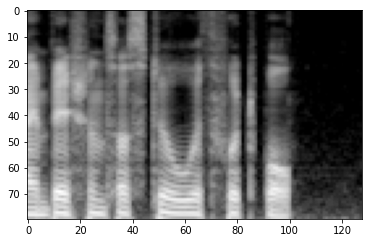

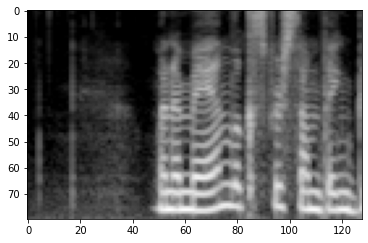

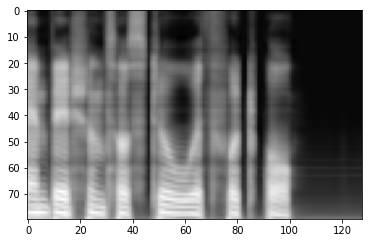

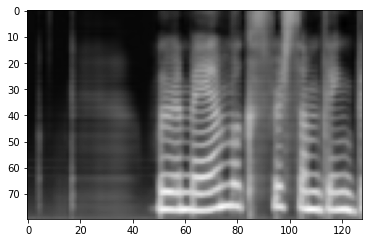

In [7]:
""" USING TENSORS PREVIOUSLY USED IN THE TRAINING MODEL THAT HAVE PROVEN TO BE RECONSTRUCTED SUCCESSFULLY"""
# speaker_ids = speaker_name[0] +speaker_name[1]
speaker_ids = 'p347p303'

file_ending = '_' +speaker_ids +'.pt'
image_comp_path = 'model_data/1Hot16FreqFrom700kIters/image_comparison/'

x_real_tensor = torch.load(image_comp_path +'mel_batch' +file_ending)
print('x_real_tensor',x_real_tensor.shape)

emb_org_tensor = torch.load(image_comp_path +'emb_org' +file_ending)
print('emb_org_tensor',emb_org_tensor.shape)

pitch_tensor = torch.load(image_comp_path +'pitch' +file_ending)
print('pitch_tensor',pitch_tensor.shape)

x_identic_psnt_tensor = torch.load(image_comp_path +'x_identic_psnt' +file_ending)

print(type(x_real_tensor), x_real_tensor.shape, x_real_tensor)
print(type(pitch_tensor), pitch_tensor.shape, pitch_tensor)
print(type(emb_org_tensor), emb_org_tensor.shape, emb_org_tensor)

"""They all match up, and basically ARE the same tensors used in training"""
   
before_after_mels(x_real_tensor)

_, x_identic_psnt_tensor, _ = G(x_real_tensor, emb_org_tensor, emb_org_tensor, pitch_tensor, pitch_tensor)
torch.save(x_identic_psnt_tensor, './model_data/' +config.file_name +'/image_comparison/x_identic_psnt_' +speaker_name[0] +speaker_name[1] +'.pt')

before_after_mels(x_identic_psnt_tensor)

Training speaker:  p244
Training speaker:  p303
Training speaker:  p376
Training speaker:  p360
Training speaker:  p341
Training speaker:  p233
Training speaker:  p259
Training speaker:  p241
Training speaker:  p293
Training speaker:  p284
Training speaker:  p287
Training speaker:  p315
Training speaker:  p275
Training speaker:  p347
Training speaker:  p253
Training speaker:  p238
Training speaker:  p292
Training speaker:  p228
Training speaker:  p364
Training speaker:  p276
org_name:  p360 trg_name p233
x_real


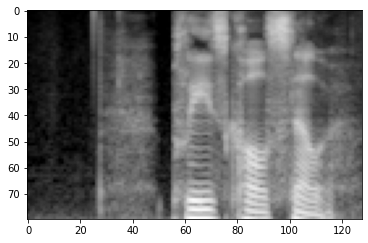

resynthesised x_identic_psnt


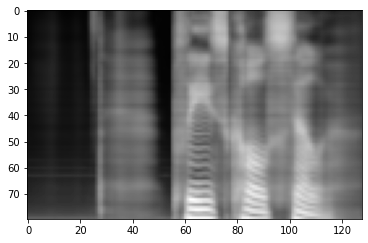

x_real


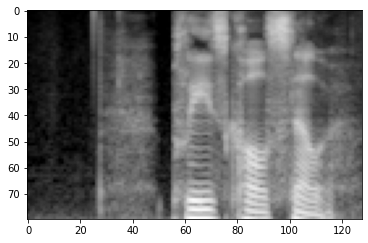

converted x_identic_psnt


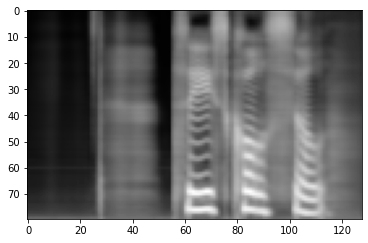

In [8]:
#================================================#
#   GENERATE LIST OF TRAINING DATA INPUT VALUES  #
#================================================#

spec_dir = 'spmel'
pitch_dir = 'pitch'
example_name = '_001_mic1'

# VIEW SPEAKERS IN EACH OF DATA
training_meta_data = pickle.load(open('./' +model_dir +'/' +model_name +'/training_meta_data.pkl', "rb"))
all_meta_data = pickle.load(open('all_meta_data.pkl', "rb"))

for i, spkr_i in enumerate(training_meta_data):
    print('Training speaker: ', spkr_i[0])

# ESTABLISH A TEST SET OF SPEAKERS

# p360  19  M    American  New  Jersey
# p259  23  M    English    Nottingham
# p233  23  F    English    Staffordshire
# p228  22  F    English    Southern  England

test_speakers = ['p360', 'p259', 'p233', 'p228']
if one_hot==True:
    test_speaker_idx = []
    for i, spkr_i in enumerate(test_speakers):
        for j, spkr_j in enumerate(training_meta_data):
            if spkr_i == spkr_j[0]:
                #print(j, spkr_i)
                test_speaker_idx.append(j)

# MAKE ONE-HOT ARRAYS
num_training_spkrs = len(training_meta_data)
if one_hot==True:
    one_hot_array = np.eye(num_training_spkrs)[np.arange(num_training_spkrs)]

test_spkr_embs = []
if one_hot==True:
    for spkr_idx in test_speaker_idx:
        spkr_emb = one_hot_array[spkr_idx]
        test_spkr_embs.append(spkr_emb)
else:
    for spkr_id_i in test_speakers:
        for spkr_data in all_meta_data:
            if spkr_id_i == spkr_data[0]:
                spkr_emb = spkr_data[1]
                test_spkr_embs.append(spkr_emb)
                
#================================================#
#  CHOOSE UTTERANCE, EMBEDDINGS AND PITCH TIERS  #
#================================================#
org_name = test_speakers[0]
org_emb = test_spkr_embs[0]
trg_name = test_speakers[2]
trg_emb = test_spkr_embs[2]


mel = np.load('./' +spec_dir +'/' +org_name +'/' +org_name  +example_name +'.npy')

print('org_name: ', org_name, 'trg_name', trg_name)

org_1hot_pitch = pickle.load(open('./' + pitch_dir +'/' +org_name +'/' +org_name +example_name +'.pkl', 'rb'))[0]

# org_1hot_pitch, _ = pad_seq(org_1hot_pitch)
org_1hot_pitch = org_1hot_pitch[:128]
org_1hot_pitch = np.expand_dims(org_1hot_pitch, 0)
pitch_tensor = torch.from_numpy(org_1hot_pitch).to(device).float()

#x_org = mel
#x_org, len_pad = pad_seq(x_org)

x_org = mel[:128]
# utterance origin is just padded spec in tensor form
x_real_tensor = torch.from_numpy(x_org[np.newaxis, :, :]).to(device)
# speaker embedding 
emb_org_tensor = torch.from_numpy(org_emb[np.newaxis, :]).to(device).float()
# embedding target represents S2 in the paper - the embedding provided by a pretrained Speaker Encoder
# I guess this converts each utterance from the data so that it matches the utterance of every speaker
# So if there were 4 utterances with different speakers, then this code will generate 4*4=16 conversions
trg_org_tensor = torch.from_numpy(trg_emb[np.newaxis, :]).to(device).float()

_, x_identic_psnt_tensor, _ = G(x_real_tensor, emb_org_tensor, emb_org_tensor, pitch_tensor, pitch_tensor)

print('x_real')
before_after_mels(x_real_tensor)

print('resynthesised x_identic_psnt')
before_after_mels(x_identic_psnt_tensor)

_, x_identic_psnt_tensor, _ = G(x_real_tensor, emb_org_tensor, trg_org_tensor, pitch_tensor, pitch_tensor)

print('x_real')
before_after_mels(x_real_tensor)

print('converted x_identic_psnt')
before_after_mels(x_identic_psnt_tensor)

In [20]:
# prepare wavenet operations

import torch
import librosa
import soundfile as sf
import pickle
from synthesis import build_model
from synthesis import wavegen

subdir_for_wavs = './' +model_dir +'/' +model_name +'/generated_wavs/' +str(ckpt_iters) +'iters'
if os.path.exists(subdir_for_wavs)==False:
        os.makedirs(subdir_for_wavs)

device = torch.device("cuda:0")
model = build_model().to(device)
checkpoint = torch.load("checkpoint_step001000000_ema.pth")
model.load_state_dict(checkpoint["state_dict"])
    
x_real = x_real_tensor.squeeze(0).cpu().numpy()
waveform = wavegen(model, c=x_real)   
#     librosa.output.write_wav(name+'.wav', waveform, sr=16000)
sf.write(subdir_for_wavs +'/' +org_name +example_name +'.wav', waveform, samplerate=16000)

x_identic_psnt = x_identic_psnt_tensor.squeeze(0).squeeze(0).detach().cpu().numpy()
waveform = wavegen(model, c=x_identic_psnt)   
#     librosa.output.write_wav(name+'.wav', waveform, sr=16000)
sf.write(subdir_for_wavs +'/' +org_name[1:] +'x' +trg_name[1:] +example_name +'.wav', waveform, samplerate=16000)

100%|██████████| 32768/32768 [08:44<00:00, 62.42it/s]


In [21]:
subdir_for_wavs

'./model_data/generated_wavs/700000iters'